# Importing the necessary library

In [0]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV
import lightgbm as lgb
from tqdm import tqdm_notebook
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
import multiprocessing
import gc

# Mounting the google drive and importing the dataset

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
files = ['../content/gdrive/My Drive/fraud_detection_data/test_identity.csv',
         '../content/gdrive/My Drive/fraud_detection_data/test_transaction.csv',
         '../content/gdrive/My Drive/fraud_detection_data/train_identity.csv',
         '../content/gdrive/My Drive/fraud_detection_data/train_transaction.csv',
         '../content/gdrive/My Drive/fraud_detection_data/sample_submission.csv']

def load_data(file):
    return pd.read_csv(file)

with multiprocessing.Pool() as pool:
    test_id, test_tr, train_id, train_tr, sub = pool.map(load_data, files)

In [0]:
train = pd.merge(train_tr, train_id, on='TransactionID', how='left',left_index=True, right_index=True)
test = pd.merge(test_tr, test_id, on='TransactionID', how='left',left_index=True, right_index=True)

# del test_id, test_tr, train_id, train_tr
# gc.collect()

# We can eleminate some useless features already at the begining. Such as:
* Features with only 1 unique value
* Features with more than 90% missing values
* Features with the top value appears more than 90% of the time

The code below will remove these features

In [0]:
one_value_cols = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]

many_null_cols = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.9]
many_null_cols_test = [col for col in test.columns if test[col].isnull().sum() / test.shape[0] > 0.9]

big_top_value_cols = [col for col in train.columns if train[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
big_top_value_cols_test = [col for col in test.columns if test[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]

cols_to_drop = list(set(many_null_cols + many_null_cols_test + big_top_value_cols + big_top_value_cols_test + one_value_cols + one_value_cols_test))
cols_to_drop.remove('isFraud')
print('{} features are going to be dropped for being useless'.format(len(cols_to_drop)))

train = train.drop(cols_to_drop, axis=1)
# test = test.drop(cols_to_drop, axis=1)

91 features are going to be dropped for being useless


KeyError: ignored

## Reduce the memory usage

In [0]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# This will label encode all the values in V

In [0]:
for col in tqdm_notebook(train.columns): 
    if train[col].dtype == 'object':
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


## Reducing the memory usage of train

In [0]:
# reducing memory for the training set
train = reduce_mem_usage(train)

Mem. usage decreased to 525.45 Mb (73.1% reduction)


In [0]:
#creating the X and y pair
X = train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
y = train.sort_values('TransactionDT')['isFraud']

del train
gc.collect()

22

In [0]:
# Replace all the NAN in X
X.fillna(-999, inplace=True)

In [0]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47
         }

## We are creating recursive feature elimination to determine which features are important 

In [0]:
clf = lgb.LGBMClassifier(**params)
rfe = RFECV(estimator=clf, step=10, cv=KFold(n_splits=5, shuffle=False), scoring='roc_auc', verbose=2)

In [0]:
rfe.fit(X, y)

Fitting estimator with 431 features.
Fitting estimator with 421 features.
Fitting estimator with 411 features.
Fitting estimator with 401 features.
Fitting estimator with 391 features.
Fitting estimator with 381 features.
Fitting estimator with 371 features.
Fitting estimator with 361 features.
Fitting estimator with 351 features.
Fitting estimator with 341 features.
Fitting estimator with 331 features.
Fitting estimator with 321 features.
Fitting estimator with 311 features.
Fitting estimator with 301 features.
Fitting estimator with 291 features.
Fitting estimator with 281 features.
Fitting estimator with 271 features.
Fitting estimator with 261 features.
Fitting estimator with 251 features.
Fitting estimator with 241 features.
Fitting estimator with 231 features.
Fitting estimator with 221 features.
Fitting estimator with 211 features.
Fitting estimator with 201 features.
Fitting estimator with 191 features.
Fitting estimator with 181 features.
Fitting estimator with 171 features.
F

RFECV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
      estimator=LGBMClassifier(bagging_fraction=0.4181193142567742,
                               bagging_seed=11, boosting_type='gbdt',
                               class_weight=None, colsample_bytree=1.0,
                               feature_fraction=0.3797454081646243,
                               importance_type='split',
                               learning_rate=0.006883242363721497, max_depth=-1,
                               metric='auc', min_child_samples=20,
                               min_child_we....03454472573214212,
                               min_data_in_leaf=106, min_split_gain=0.0,
                               n_estimators=100, n_jobs=-1, num_leaves=491,
                               objective='binary', random_state=47,
                               reg_alpha=0.3899927210061127,
                               reg_lambda=0.6485237330340494, silent=True,
                               subsam

In [0]:
print('Optimal number of features:', rfe.n_features_)

Optimal number of features: 261


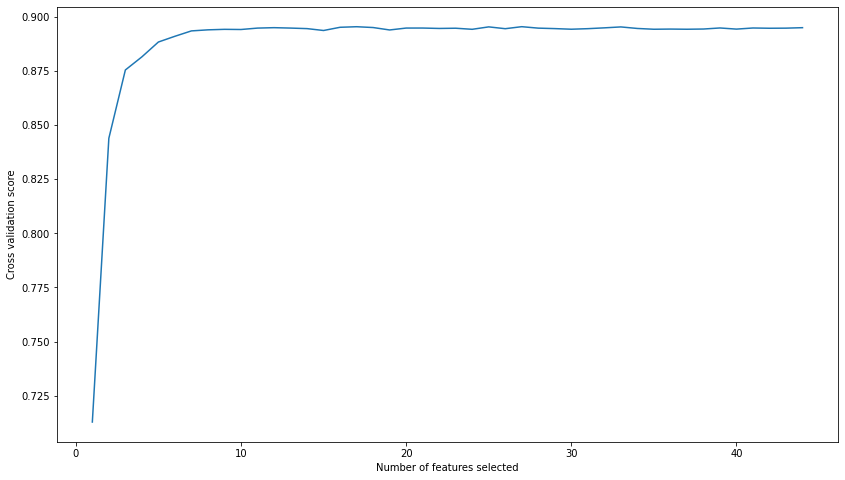

In [0]:
plt.figure(figsize=(14, 8))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfe.grid_scores_) + 1), rfe.grid_scores_)
plt.show()

In [0]:
for col in X.columns[rfe.ranking_ == 1]:
    print(col)

TransactionAmt
ProductCD
card1
card2
card3
card4
card5
card6
addr1
addr2
dist1
dist2
P_emaildomain
R_emaildomain
C1
C2
C4
C5
C6
C7
C8
C9
C10
C11
C12
C13
C14
D1
D2
D3
D4
D5
D6
D7
D8
D9
D10
D11
D12
D13
D14
D15
M2
M3
M4
M5
M6
M7
M8
M9
V3
V4
V5
V7
V12
V13
V17
V19
V20
V23
V24
V25
V26
V29
V30
V33
V34
V35
V36
V37
V38
V39
V40
V43
V44
V45
V47
V48
V49
V52
V53
V54
V55
V56
V57
V58
V60
V61
V62
V63
V64
V66
V67
V69
V70
V73
V74
V75
V76
V77
V78
V81
V82
V83
V86
V87
V90
V91
V94
V96
V97
V99
V100
V102
V103
V105
V115
V124
V126
V127
V128
V129
V130
V131
V132
V133
V134
V135
V136
V137
V139
V140
V143
V145
V149
V150
V152
V156
V160
V162
V165
V167
V168
V169
V170
V171
V187
V188
V189
V200
V201
V202
V203
V204
V205
V206
V207
V208
V209
V210
V211
V212
V213
V215
V217
V218
V219
V221
V222
V223
V224
V228
V229
V231
V232
V234
V243
V245
V251
V253
V256
V257
V258
V259
V260
V261
V262
V263
V264
V265
V266
V267
V268
V270
V271
V272
V273
V274
V275
V277
V278
V279
V280
V281
V282
V283
V284
V285
V286
V287
V288
V289
V290
V291
V292
V293
V294